In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import io
from scipy import ndimage

In [492]:
from matplotlib.collections import LineCollection
def plot_multicolor(x,y,ax,linewidth=1,f=1, cmap='magma'):
    t = np.tile(np.linspace(0,1,len(x)//f),f)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(t.min(), t.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(linewidth)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    
def plot_polar(landmark_phases,ax):
    nbins = 50
    bottom = 8
    max_height = 4

    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = max_height*np.random.rand(N)
    width = (2*np.pi) / (nbins+10)

    for i in landmarks:
        n, bins = np.histogram(landmark_phases[i],bins=nbins,
                               range=(-np.pi,np.pi))
        bars = ax.bar(bins[:-1], n,
                      width=width, bottom=bottom, label=landmark_names[i])

    ax.set_yticklabels([]);
    plt.legend();

1. all_maps: n_cells x n_trials x n_spatial bins. Spike times binned in 2cm spatial bins, divided by occupancy, and smoothed with a 2-bin standard deviation Gaussian. 

2. trial_starts: n_blocks x 1. Goes with all_maps, and indicates the trial numbers corresponding to the beginning of each new block.

3. all_fr: n_cells x n_timebins. Spike times binned in 0.02s and smoothed with a 2-bin standard deviation Gaussian. 

4. time_starts: n_blocks x 1. Goes with all_fr, and indicates the timebins corresponding to the beginning of each new block.

5. spike_times: n_cells x 1. A cell array containing the spike times for each cell. 

6. spike_depth: n_cells x 1. Contains the depth of each cell. Calculated as the median depth of the spikes from each cell. 

7. spike_template: n_cells x 82. Contains the whitened spike template for each cell.

8. spike_dur: n_cells x 1. Contains the duration of each spike in samples.

9. posx: n_timebins x 1. The position of the mouse at each timebin.

10. post: n_timebins x 1. The time from beginning of recording at each timebin

11. lickx: n_licks x 1. The position of the mouse for each detected lick.

12. lickt: n_licks x 1. The time from beginning of recording of each lick

In [3]:
data = io.loadmat('N2_200204_track9_BenSorscher(1).mat')

In [4]:
maps = data['all_maps']
nx = maps.shape[-1]
N = maps.shape[0]

trial_starts = data['trial_starts'].squeeze()
trial_starts = trial_starts - 1    # matlab indexing

In [978]:
# Take the first 100 trials
dark_maps = maps[:,:200].reshape(N,-1)

# z-score
mean = dark_maps.mean(-1,keepdims=True)
std = dark_maps.std(-1,keepdims=True)
dark_maps = (dark_maps - mean)/std

# Feature maps
feat_maps = maps[:,400:440].reshape(N,-1)
feat_maps = (feat_maps - mean)/std
feat_maps = feat_maps.reshape(N,-1,nx)

In [979]:
# # # Try a bit more smoothing
# from scipy import ndimage
# dark_maps = ndimage.gaussian_filter1d(dark_maps, 3, axis=-1)

# Fourier transform

In [980]:
dm_fft = np.fft.fft(dark_maps, axis=-1)

dx = 2   # 2cm
freqs = np.fft.fftfreq(dark_maps.shape[-1], dx)
idxs = np.argsort(freqs)
idxs = idxs[np.abs(freqs[idxs])<0.025]

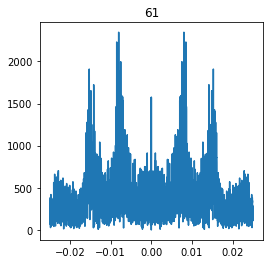

In [981]:
# Pick a template cell
template_id = 61
plt.figure(figsize=(4,4))
plt.plot(freqs[idxs], np.abs(dm_fft)[template_id][idxs])
plt.title(template_id);

36


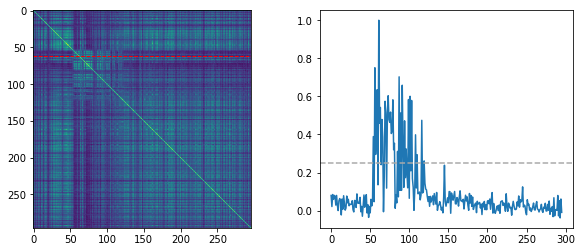

In [982]:
thresh = 0.25
rs = np.corrcoef(np.abs(dm_fft[:,idxs]))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(rs)
plt.axhline(template_id, c='red', linewidth=1, linestyle='dashed')
plt.subplot(122)
plt.plot(rs[template_id])
plt.axhline(thresh, c='darkgrey', linestyle='dashed')
grid_cell_idxs = np.where(rs[template_id] > thresh)[0]
print(len(grid_cell_idxs))

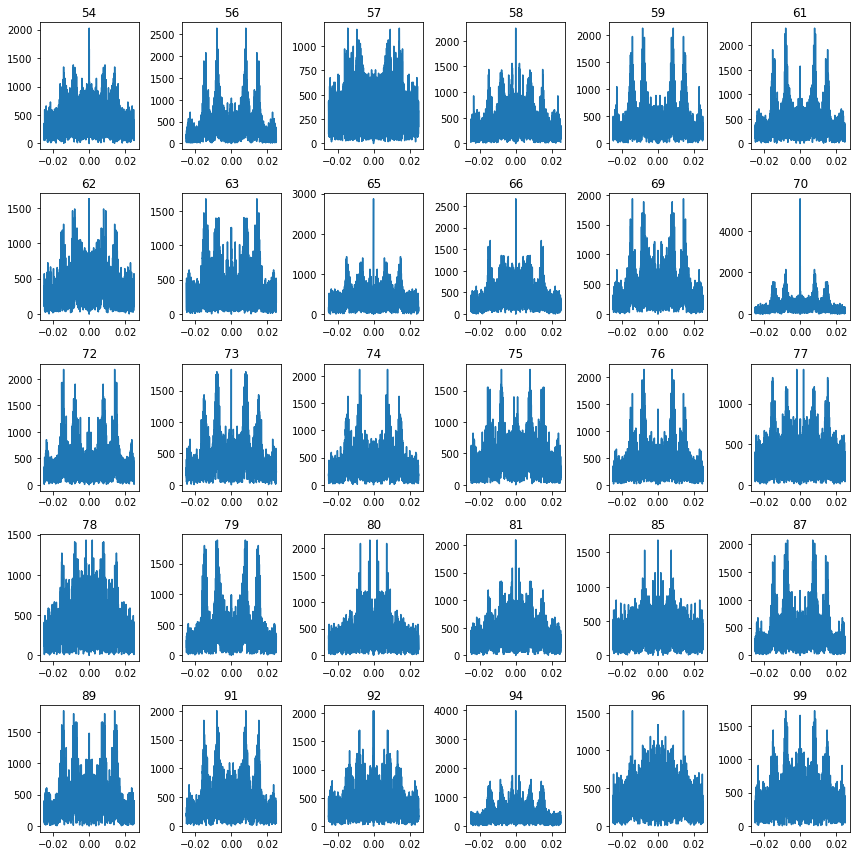

In [983]:
plt.figure(figsize=(12,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.plot(freqs[idxs], np.abs(dm_fft)[grid_cell_idxs][i][idxs])
    plt.title(grid_cell_idxs[i])
#     plt.ylim([0,2000])
plt.tight_layout()

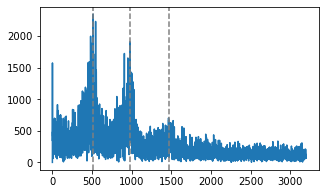

In [984]:
T = dark_maps.shape[-1]

power = np.abs(dm_fft[template_id])
peak1 = T//80 + np.argmax(power[T//80:T//40])
peak2 = T//40 + np.argmax(power[T//40:T//25])
peak3 = T//25 + np.argmax(power[T//25:T//10])

plt.figure(figsize=(5,3))
plt.plot(power[:T//10])
plt.axvline(peak1, c='grey', linestyle='dashed')
plt.axvline(peak2, c='grey', linestyle='dashed')
plt.axvline(peak3, c='grey', linestyle='dashed')

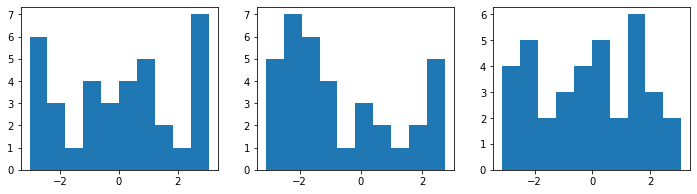

In [985]:
phases1 = np.angle(dm_fft[grid_cell_idxs,peak1])
phases2 = np.angle(dm_fft[grid_cell_idxs,peak2])
phases3 = np.angle(dm_fft[grid_cell_idxs,peak3])
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(phases1)
plt.subplot(1,3,2)
plt.hist(phases2)
plt.subplot(1,3,3)
plt.hist(phases3);

In [986]:
X = dark_maps[grid_cell_idxs]
u1 = np.cos(phases1)@X/np.linalg.norm(np.cos(phases1))
v1 = np.sin(phases1)@X/np.linalg.norm(np.sin(phases1))
u2 = np.cos(phases2)@X/np.linalg.norm(np.cos(phases1))
v2 = np.sin(phases2)@X/np.linalg.norm(np.sin(phases1))
u3 = np.cos(phases3)@X/np.linalg.norm(np.cos(phases1))
v3 = np.sin(phases3)@X/np.linalg.norm(np.sin(phases1))
X2 = np.stack([u1,v1,u2,v2,u3,v3])
print('Variance explained by 2d phase projection: {:.2f}%'.format(
    100*np.trace(np.cov(X2))/np.trace(np.cov(X))))

Variance explained by 2d phase projection: 38.68%


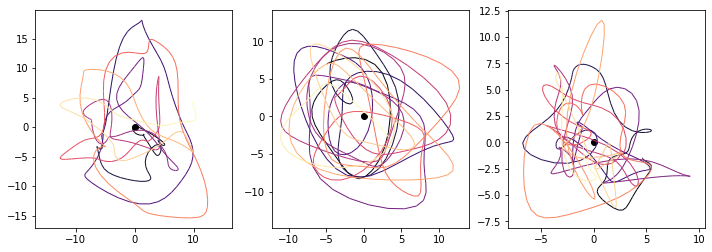

In [613]:
phases_all = [phases1,phases2,phases3]
X = dark_maps[grid_cell_idxs]
plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    u = ndimage.gaussian_filter1d(np.cos(phases_all[i])@X,3)
    v = ndimage.gaussian_filter1d(np.sin(phases_all[i])@X,3)
    plot_multicolor(u[:500], v[:500], ax)
    plt.scatter(0,0, c='black')
    plt.axis('equal')

In [392]:
U,S,V = np.linalg.svd(dark_maps[grid_cell_idxs])

print('Participation ratio: {:.2f}'.format((S**2).sum()**2/(S**4).sum()))
print('Variance explained by top two PCs: {:.2f}%'.format(
    100*(S[:2]**2).sum()/(S**2).sum()))

# Project onto sin(phi), cos(phi)
X = dark_maps[grid_cell_idxs]
u = np.cos(phases1)@X/np.linalg.norm(np.cos(phases1))
v = np.sin(phases1)@X/np.linalg.norm(np.sin(phases1))
X2 = np.stack([u,v])
print('Variance explained by 2d phase projection: {:.2f}%'.format(
    100*np.trace(np.cov(X2))/np.trace(np.cov(X))))

Participation ratio: 19.08
Variance explained by top two PCs: 22.37%
Variance explained by 2d phase projection: 13.07%


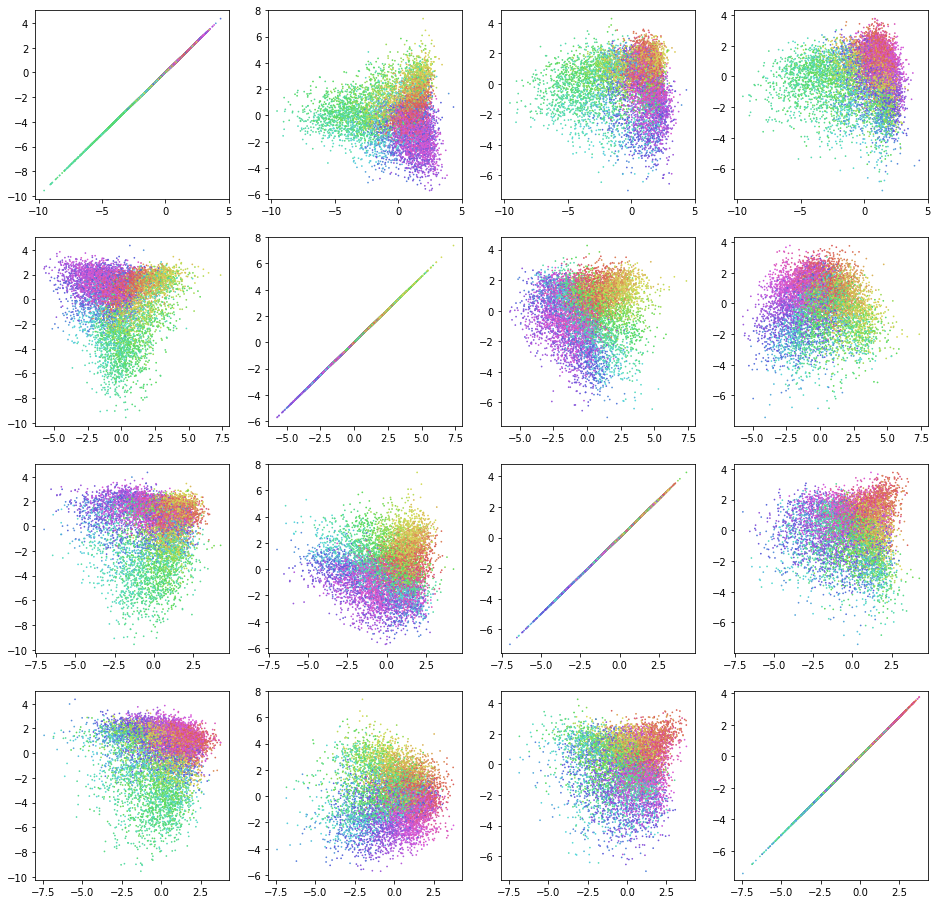

In [178]:
cmap = sns.color_palette('hls', 500, as_cmap=True)
u = np.cos(phases2)@dark_maps[grid_cell_idxs]
v = np.sin(phases2)@dark_maps[grid_cell_idxs]


fig, ax = plt.subplots(4,4,figsize=(16,16))
for ii in range(4):
    for jj in range(4):
        ax[ii,jj].scatter(U[:,ii]@dark_maps[grid_cell_idxs],
                          U[:,jj]@dark_maps[grid_cell_idxs],
                    c=np.arctan2(v,u),s=0.5, alpha=1, cmap=cmap)
        plt.axis('equal')

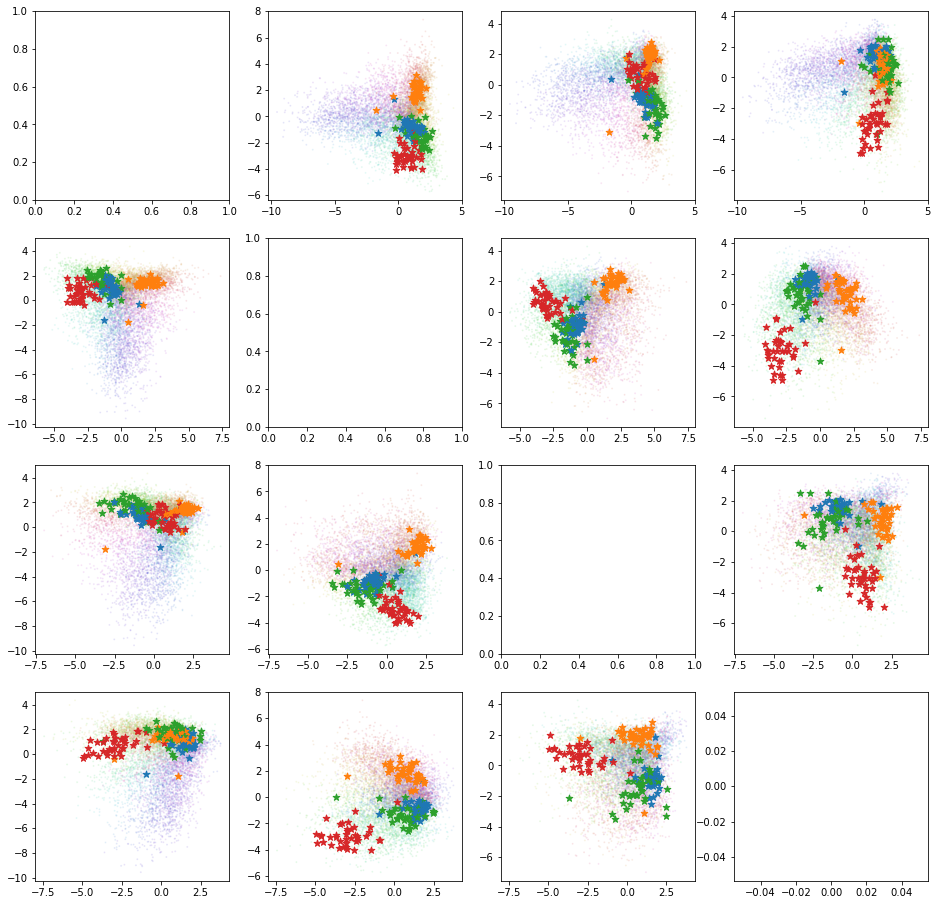

In [179]:
w = 3
u = np.cos(phases1)@dark_maps[grid_cell_idxs]
v = np.sin(phases1)@dark_maps[grid_cell_idxs]
fig, ax = plt.subplots(4,4,figsize=(16,16))
for ii in range(4):
    for jj in range(4):
        if ii!=jj:
            landmarks = [15,60,95,130]
            ax[ii,jj].scatter(U[:,ii]@dark_maps[grid_cell_idxs],
                          U[:,jj]@dark_maps[grid_cell_idxs],
                    c=np.arctan2(v,u),s=1, alpha=0.1, cmap=cmap)
            for i in range(40):
                u2 = U[:,ii]@feat_maps[grid_cell_idxs][:,i]
                v2 = U[:,jj]@feat_maps[grid_cell_idxs][:,i]
                for ic,j in enumerate(landmarks):
                    ax[ii,jj].scatter(u2[j-w:j+w].mean(),v2[j-w:j+w].mean(),
                                      marker='*',s=50,c='C'+str(ic))
            plt.axis('equal')

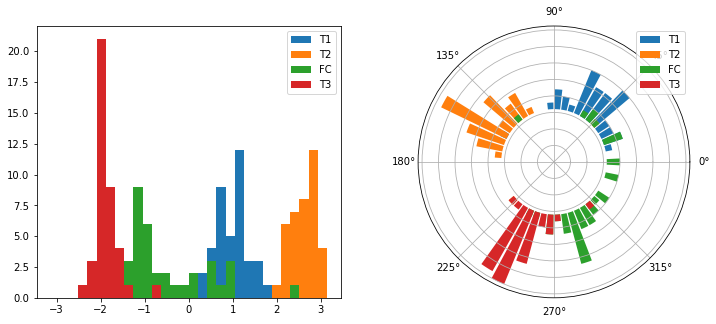

In [17]:
landmarks = [15,60,95,130]
landmark_names = {15:'T1', 60:'T2', 95:'FC', 130:'T3'}
w = 5   # window for average
landmark_phases = {}
for i in landmarks:
    landmark_phases[i] = []
for i in range(40):
    u2 = np.cos(phases1)@feat_maps[grid_cell_idxs][:,i]
    v2 = np.sin(phases1)@feat_maps[grid_cell_idxs][:,i]
    for ic,j in enumerate(landmarks):
        landmark_phases[j].append(np.arctan2(v2[j-w:j+w].mean(),
                                             u2[j-w:j+w].mean()))
        
plt.figure(figsize=(12,5))
plt.subplot(121)
for i in landmarks:
    plt.hist(landmark_phases[i], range=(-np.pi, np.pi), bins=30,
                                 label=landmark_names[i])
plt.legend()
ax = plt.subplot(122,polar=True)
plot_polar(landmark_phases,ax)

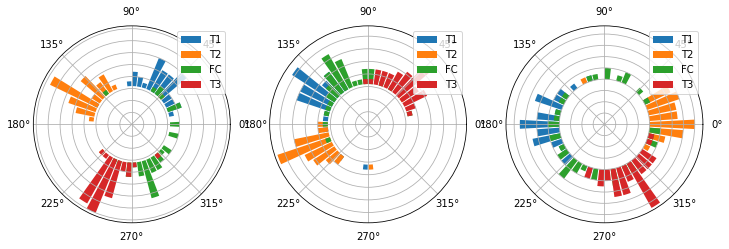

In [19]:
landmarks = [15,60,95,130]
landmark_names = {15:'T1', 60:'T2', 95:'FC', 130:'T3'}
w = 5   # window for average

plt.figure(figsize=(12,5))
phases_all = [phases1,phases2,phases3]
for ii in range(3):
    ax = plt.subplot(1,3,ii+1, polar=True)
    landmark_phases = {}
    for i in landmarks:
        landmark_phases[i] = []
    for i in range(40):
        u2 = np.cos(phases_all[ii])@feat_maps[grid_cell_idxs][:,i]
        v2 = np.sin(phases_all[ii])@feat_maps[grid_cell_idxs][:,i]
        for ic,j in enumerate(landmarks):
            landmark_phases[j].append(np.arctan2(v2[j-w:j+w].mean(),
                                                 u2[j-w:j+w].mean()))
    plot_polar(landmark_phases,ax)

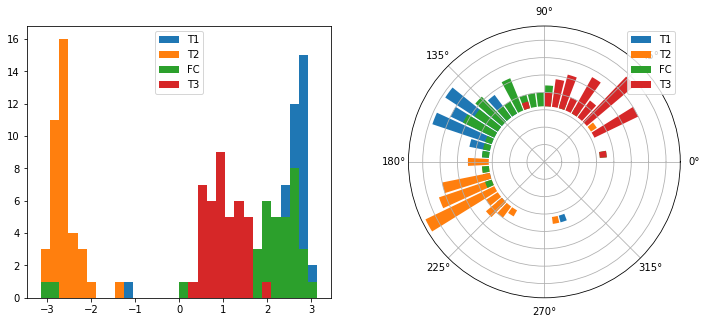

In [1390]:
landmarks = [15,60,95,130]
landmark_names = {15:'T1', 60:'T2', 95:'FC', 130:'T3'}
w = 5   # window for average
landmark_phases = {}
for i in landmarks:
    landmark_phases[i] = []
for i in range(40):
    u2 = np.cos(phases2)@feat_maps[grid_cell_idxs][:,i]
    v2 = np.sin(phases2)@feat_maps[grid_cell_idxs][:,i]
    for ic,j in enumerate(landmarks):
        landmark_phases[j].append(np.arctan2(v2[j-w:j+w].mean(),
                                             u2[j-w:j+w].mean()))
        
plt.figure(figsize=(12,5))
plt.subplot(121)
for i in landmarks:
    plt.hist(landmark_phases[i], range=(-np.pi, np.pi), bins=30,
                                 label=landmark_names[i])
plt.legend()
ax = plt.subplot(122,polar=True)
plot_polar(landmark_phases,ax)

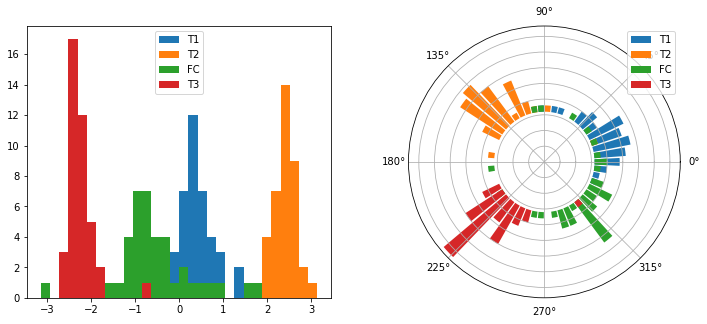

In [1350]:
landmarks = [15,60,95,130]
landmark_names = {15:'T1', 60:'T2', 95:'FC', 130:'T3'}
w = 5   # window for average
landmark_phases = {}
for i in landmarks:
    landmark_phases[i] = []
for i in range(40):
    u2 = np.cos(phases1)@feat_maps[grid_cell_idxs][:,i]
    v2 = np.sin(phases1)@feat_maps[grid_cell_idxs][:,i]
    for ic,j in enumerate(landmarks):
        landmark_phases[j].append(np.arctan2(v2[j-w:j+w].mean(),
                                             u2[j-w:j+w].mean()))
        
plt.figure(figsize=(12,5))
plt.subplot(121)
for i in landmarks:
    plt.hist(landmark_phases[i], range=(-np.pi, np.pi), bins=30,
                                 label=landmark_names[i])
plt.legend()
ax = plt.subplot(122,polar=True)
plot_polar(landmark_phases,ax)

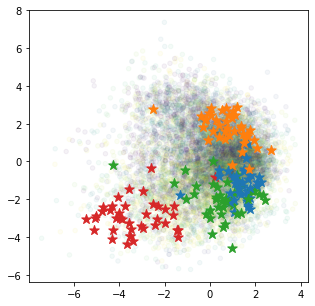

In [736]:
plt.figure(figsize=(5,5))
landmarks = [15,60,95,130]
plt.scatter(U[:,3]@dark_maps[grid_cell_idxs], U[:,1]@dark_maps[grid_cell_idxs],
            c=np.fft.ifft(test),s=20, alpha=0.05)
for i in range(40):
    u2 = U[:,3]@feat_maps[grid_cell_idxs][:,i]
    v2 = U[:,1]@feat_maps[grid_cell_idxs][:,i]
    for ii,j in enumerate(landmarks):
        plt.scatter(u2[j],v2[j],marker='*',s=100,c='C'+str(ii))

(-4.924596347299206, 7.067910391708513, -6.861369343823462, 5.783777405756299)

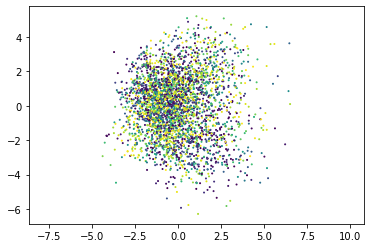

In [874]:
plt.scatter(U[:,3]@dark_maps[grid_cell_idxs], U[:,1]@dark_maps[grid_cell_idxs],
            c=np.fft.ifft(test),s=1, alpha=1)
plt.axis('equal')

# Integration

In [1416]:
phases = phases1
peak = peak1
smooth = 2

In [1417]:
u = np.cos(phases)@dark_maps[grid_cell_idxs]
v = np.sin(phases)@dark_maps[grid_cell_idxs]

# u = U[:,0]@dark_maps[grid_cell_idxs]
# v = U[:,1]@dark_maps[grid_cell_idxs]

In [1418]:
from scipy import ndimage
usmooth = ndimage.gaussian_filter1d(u, smooth)
vsmooth = ndimage.gaussian_filter1d(v, smooth)
norm1 = np.sqrt(usmooth**2 + vsmooth**2)

dv = np.diff(vsmooth)
du = np.diff(usmooth)
norm2 = np.sqrt(dv**2+du**2)
dphi = (-dv*usmooth[1:] + du*vsmooth[1:])

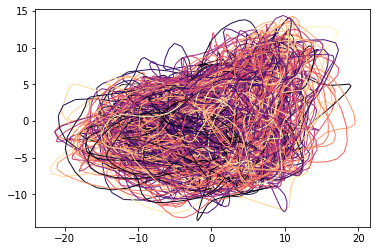

In [1419]:
fig,ax = plt.subplots()
for i in range(100):
    plot_multicolor(usmooth.reshape(nx,-1)[i],
                    vsmooth.reshape(nx,-1)[i], ax)
plt.axis('equal');

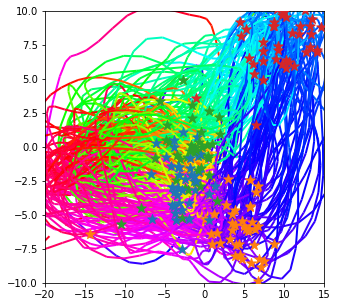

In [1420]:
u2 = np.cos(phases)@feat_maps.reshape(N,-1)[grid_cell_idxs]
v2 = np.sin(phases)@feat_maps.reshape(N,-1)[grid_cell_idxs]
# u2 = U[:,0]@feat_maps.reshape(N,-1)[grid_cell_idxs]
# v2 = U[:,1]@feat_maps.reshape(N,-1)[grid_cell_idxs]

from scipy import ndimage
u2smooth = ndimage.gaussian_filter1d(u2, smooth)
v2smooth = ndimage.gaussian_filter1d(v2, smooth)
norm1 = np.sqrt(u2smooth**2 + v2smooth**2)

d2v = np.diff(v2smooth)
d2u = np.diff(u2smooth)
norm2 = np.sqrt(d2v**2+d2u**2)
d2phi = (-d2v*u2smooth[1:] + d2u*v2smooth[1:])
phi2 = np.arctan2(v2smooth,u2smooth)

u2smooth = u2smooth.reshape(-1,nx)
v2smooth = v2smooth.reshape(-1,nx)


fig, ax = plt.subplots(figsize=(5,5))
for i in range(40):
    plot_multicolor(u2smooth[i], v2smooth[i],
                    ax, linewidth=2, f=2, cmap='hsv')
    for ii,j in enumerate(landmarks):
        plt.scatter(u2smooth[i][j],v2smooth[i][j],
                    marker='*',s=100,c='C'+str(ii), zorder=99)
        
plt.xlim(-20,15)
plt.ylim(-10,10);
# plt.axis('equal');

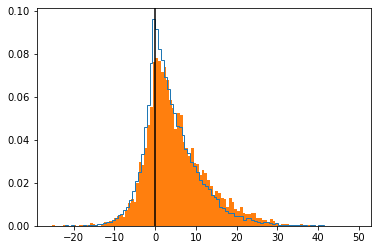

In [1421]:
plt.hist(dphi, bins=100, histtype='step', density=True);
plt.hist(d2phi, bins=100, density=True);
plt.axvline(0,c='black')

In [1422]:
u2smooth = ndimage.gaussian_filter1d(u2, smooth)
v2smooth = ndimage.gaussian_filter1d(v2, smooth)
norm1 = np.sqrt(u2smooth**2 + v2smooth**2)

d2v = np.diff(v2smooth)
d2u = np.diff(u2smooth)
norm2 = np.sqrt(d2v**2+d2u**2)
d2phi = (-d2v*u2smooth[1:] + d2u*v2smooth[1:]) 
# d2phi = np.clip(d2phi,-0.1,0.2)
phi2 = np.arctan2(v2smooth,u2smooth)

u2smooth = u2smooth.reshape(-1,nx)
v2smooth = v2smooth.reshape(-1,nx)

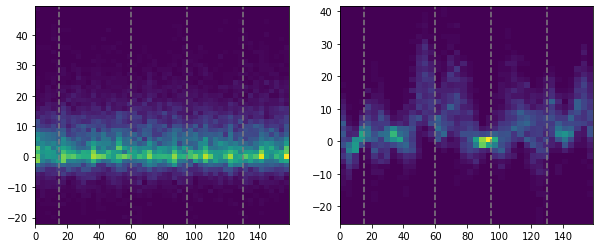

In [1423]:
plt.figure(figsize=(10,4))
plt.subplot(121)
xx = np.tile(np.arange(nx), dark_maps.shape[-1]//nx)
plt.hist2d(xx[1:], dphi, bins=50);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');
plt.subplot(122)
xx = np.tile(np.arange(nx), 40)
plt.hist2d(xx[1:], d2phi, bins=40);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');

In [1424]:
v = np.stack([np.diff(usmooth.ravel()), np.diff(vsmooth.ravel())])
v /= np.linalg.norm(v,axis=0)
k = np.sqrt((np.diff(v,axis=-1)**2).sum(0))
k = np.nan_to_num(ndimage.gaussian_filter1d(k, 10))

v = np.stack([np.diff(u2smooth.ravel()), np.diff(v2smooth.ravel())])
v /= np.linalg.norm(v,axis=0)
k2 = np.sqrt((np.diff(v,axis=-1)**2).sum(0))
k2 = np.nan_to_num(ndimage.gaussian_filter1d(k2, 10))

<ipython-input-1424-f934d9068f59>:2: RuntimeWarning: invalid value encountered in true_divide
  v /= np.linalg.norm(v,axis=0)


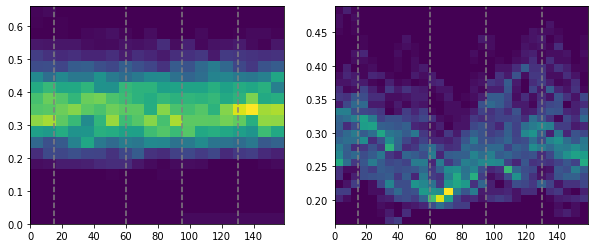

In [1425]:
plt.figure(figsize=(10,4))
plt.subplot(121)
xx = np.tile(np.arange(nx), dark_maps.shape[-1]//nx)
plt.hist2d(xx[2:], k, bins=20);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');
plt.subplot(122)
xx = np.tile(np.arange(nx), 40)
plt.hist2d(xx[2:], k2, bins=30);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');

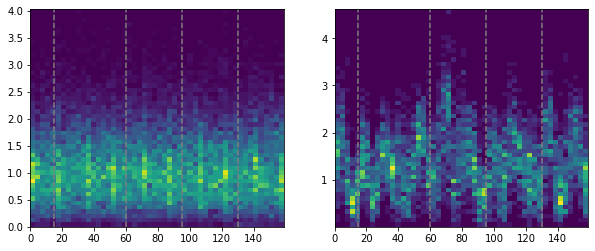

In [1426]:
speed = np.sqrt(np.diff(usmooth)**2 + np.diff(vsmooth)**2)
speed2 = np.sqrt(np.diff(u2smooth.ravel())**2 + np.diff(v2smooth.ravel())**2)

plt.figure(figsize=(10,4))
plt.subplot(121)
xx = np.tile(np.arange(nx), dark_maps.shape[-1]//nx)
plt.hist2d(xx[1:], speed, bins=50);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');
plt.subplot(122)
xx = np.tile(np.arange(nx), 40)
plt.hist2d(xx[1:], speed2, bins=50);
for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed');

In [1427]:
from scipy.stats import binned_statistic

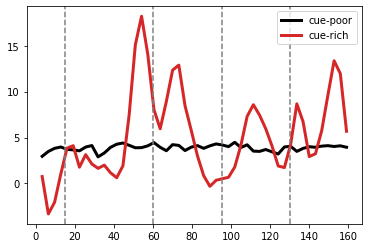

In [1428]:
xx = np.tile(np.arange(nx), dark_maps.shape[-1]//160)
means,bins,_ = binned_statistic(xx[:-1], dphi, statistic='mean', bins=50)
plt.plot(bins[1:], means, linewidth=3, c='black', label='cue-poor')

xx2 = np.tile(np.arange(nx), 40)
means,bins,_ = binned_statistic(xx2[:-1], d2phi, statistic='mean', bins=50)
plt.plot(bins[1:], means, linewidth=3, c='C3', label='cue-rich')

for i in landmarks:
    plt.axvline(i, c='grey', linestyle='dashed')
plt.legend()

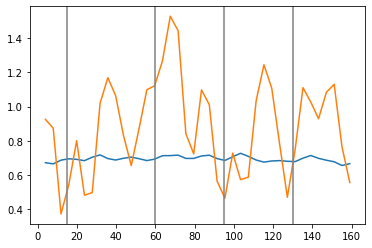

In [1372]:
xx = np.tile(np.arange(nx), dark_maps.shape[-1]//160)
means,bins,_ = binned_statistic(xx[:-1], speed, statistic='mean', bins=40)
plt.plot(bins[1:], means)

xx2 = np.tile(np.arange(nx), 40)
means,bins,_ = binned_statistic(xx2[:-1], speed2, statistic='mean', bins=40)
plt.plot(bins[1:], means)

for i in landmarks:
    plt.axvline(i, c='grey')

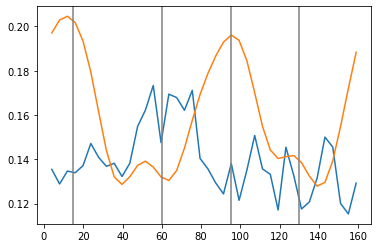

In [1375]:
speed = np.linalg.norm(np.diff(dark_maps[grid_cell_idxs],axis=-1),axis=0)
# speed2 = np.linalg.norm(np.diff(feat_maps.reshape(N,-1)[grid_cell_idxs],axis=-1),axis=0)

xx = np.repeat(np.arange(nx), dark_maps.shape[-1]//160)
means,bins,_ = binned_statistic(xx[:-2], k, statistic='mean', bins=40)
plt.plot(bins[1:], means)

xx2 = np.tile(np.arange(nx), 40)
means,bins,_ = binned_statistic(xx2[:-2], k2, statistic='mean', bins=40)
plt.plot(bins[1:], means)

for i in landmarks:
    plt.axvline(i, c='grey')

# Movies

<IPython.core.display.Javascript object>


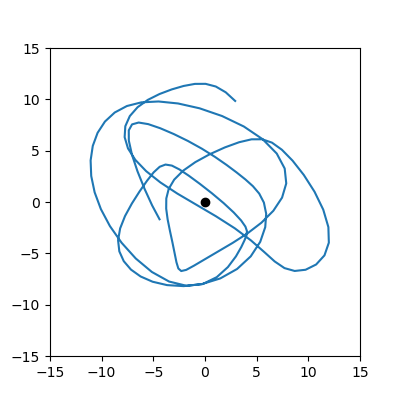

In [127]:
import matplotlib.animation as animation

u = ndimage.gaussian_filter1d(np.cos(phases2)@X,3)
v = ndimage.gaussian_filter1d(np.sin(phases2)@X,3)
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(0,0, c='black')

line, = ax.plot(u[:2],v[:2])

def animate(i):
    line.set_data(u[np.maximum(i-100,50):50+i], v[np.maximum(i-100,50):50+i])
    return line,

ani = animation.FuncAnimation(
    fig, animate, frames=1000, interval=20, blit=True, save_count=50)

plt.xlim([-15,15])
plt.ylim([-15,15])
plt.show()

# Set up formatting for the movie files
writergif = animation.PillowWriter(fps=30) 
ani.save('integration.gif', writer=writergif)

# isomap

In [912]:
from sklearn.manifold import Isomap

In [913]:
X = dark_maps[grid_cell_idxs]

In [922]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X.T)

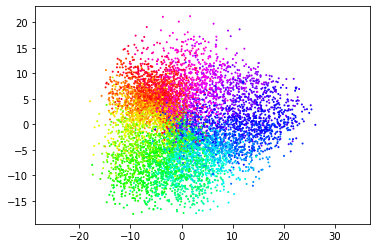

In [970]:
u = np.cos(phases1)@dark_maps[grid_cell_idxs]
v = np.sin(phases1)@dark_maps[grid_cell_idxs]
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=1, c=np.arctan2(v,u), cmap='hsv')
plt.axis('equal');

In [942]:
feat_maps.reshape(N,-1)[grid_cell_idxs][:,0].shape

(37,)

In [963]:
Y = embedding.transform(feat_maps.reshape(N,-1)[grid_cell_idxs].T)

In [964]:
Y = ndimage.gaussian_filter1d(Y,2,axis=0)

In [965]:
Y = Y.reshape(40,nx,2)

(-20.100140164393085,
 28.37674813535411,
 -19.45935062032118,
 23.091054012630106)

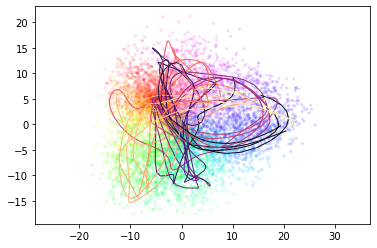

In [966]:
fig, ax = plt.subplots()
plt.scatter(X_transformed[:,0], X_transformed[:,1], 
            s=5, c=np.arctan2(v,u), cmap='hsv', alpha=0.1)

for i in range(5):
    plot_multicolor(Y[i,:,0], Y[i,:,1], ax)
plt.axis('equal')